Using this to plot distributions of reaction centres of TS structures from initial model (D_init), final model (D,after NLS optimisation), ground truth, and linear approximation.
**Note**: reaction core created by observing adjacency matrix. 
 
**TODO**: 
- All for test geometries currently. Ideally, want to do on train/val too to see how the model develops.
- All for D_init currently. Want to do similar for W and GNN embedding.
- Can optimise the D_init here OR could save D_init and optimised version during training/testing. 


In [2]:
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem

import numpy as np
from scipy import stats
from scipy.optimize import least_squares
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sys.path.insert(0, "Users/rmhavij/ts_gen/create_figs/scripts/")
# from gaussian import Gaussian

In [5]:
base_folder = r'../data/raw/' # normal
# base_folder = 'Users/rmhavij/3d-reactions/data/raw/' # azure

test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
model_ts_no_opt_file = base_folder + 'model_ts.sdf'

test_r = Chem.SDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]

test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]

test_p = Chem.SDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

# will need to add my non-optimised versions later
model_ts_no_opt = Chem.SDMolSupplier('data/model_ts.sdf', removeHs=False, sanitize=False)
model_ts_no_opt = [x for x  in model_ts_no_opt]

In [6]:
# don't need their final D. just D_init, GT, LA

# their model D_init
D_init = np.load('data/D_init.npy')

# all the other D_init runs
d_inits = []
# file_base_folder = 'log/'



# layers = 2, iterations = 3
#D_init1 = np.load(file_base_folder + '21Jul03_1253PM/D_init.npy') # e = 5, h = 128
#d_inits.append(D_init1)
#D_init2 = np.load(file_base_folder + '21Jul04_0145PM/D_init.npy') # e = 5, h = 64
#d_inits.append(D_init2)
#D_init3 = np.load(file_base_folder + '21Jul04_0320PM/D_init.npy') # e = 5, h = 32
#d_inits.append(D_init3)
#D_init4 = np.load(file_base_folder + '21Jul04_0401PM/D_init.npy') # e = 10, h = 64
#d_inits.append(D_init4)
num_d_inits = len(d_inits)

In [30]:
# check triangle inequalities for model structures before optimisation
from itertools import permutations

for mol in model_ts_no_opt:
    d = Chem.Get3DDistanceMatrix(mol)
    for p in permutations(range(6), 3):
        assert(d[p[0], p[1]] + d[p[0], p[2]] >= d[p[1], p[2]])

In [ ]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for i, d_init_list in enumerate(d_init_lists):
        d_init_lists[i].append(np.ravel(d_inits[i][idx][0:num_atoms, 0:num_atoms]*core_mask))
    
# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]
all_ds = [ds[ds != 0] for ds in all_ds]
ds_dict = {'gt': (all_ds[0], 'Ground Truth'), 'best_init': (all_ds[1], 'MIT D_init'),\
     'lin_approx': (all_ds[2], 'Linear Approximation')}
base_ds_counter = len(ds_dict)
for i in range(len(d_init_lists)):
    name = f'D_init{i+1}'
    ds_dict[name] = (all_ds[base_ds_counter + i], name)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = ['lin_approx']

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

## Ensemble
Average out all the $D_{init}$ and then plots. Similar with $W$ and $X$.

In [ ]:
# averaged ensemble of d_inits
ensemble_ds = []
d_inits
for i in range(len(ds_dict['best_init'][0])):
    ensemble_d = 0
    for j in range(1, num_d_inits + 1):
        ensemble_d += ds_dict[f'D_init{j}'][0][i]
    ensemble_d /= num_d_inits
    ensemble_ds.append(ensemble_d)

ds_dict['ens'] = (ensemble_ds, "Avg Ensemble D_init")

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = ['lin_approx']
print_d_init = False
if not print_d_init:
    for j in range(1, num_d_inits + 1):
        no_print.append(f'D_init{j}')

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

## Doing the same but on the training set to identify deviation from R and P.

In [2]:
# base_folder = r'../data/raw/' # normal
base_folder = 'Users/rmhavij/3d-reactions/data/raw/' # azure

train_reactant_file = base_folder + 'train_reactants.sdf'
train_ts_file = base_folder + 'train_ts.sdf'
train_product_file = base_folder + 'train_products.sdf'

train_r = Chem.SDMolSupplier(train_reactant_file, removeHs=False, sanitize=False)
train_r = [x for x in train_r]

train_ts = Chem.SDMolSupplier(train_ts_file, removeHs=False, sanitize=False)
train_ts = [ts for ts in train_ts]

train_p = Chem.SDMolSupplier(train_product_file, removeHs=False, sanitize=False)
train_p = [x for x  in train_p]

In [50]:
# all for reaction core

train_gt = [] # ground truth
train_la = [] # linear approximation

num_train_mols = len(train_r)

for idx in range(num_train_mols):

    # get N and create mask for reaction core based off adjacency matrices
    N = train_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(train_r[idx]) + Chem.GetAdjacencyMatrix(train_p[idx])) == 1   

    train_gt.append(np.ravel(Chem.Get3DDistanceMatrix(train_ts[idx]) * core_mask))
    train_la.append(np.ravel(((Chem.Get3DDistanceMatrix(train_r[idx]) + Chem.Get3DDistanceMatrix(train_p[idx]))/2) * core_mask))
    
    # TODO: create and add in training D_init here

# concat + ravel
train_gt_all = np.concatenate(train_gt).ravel()
train_la_all = np.concatenate(train_la).ravel()

# remove all atoms that haven't moved
train_gt_all = train_gt_all[train_gt_all != 0]
train_la_all = train_la_all[train_la_all != 0]

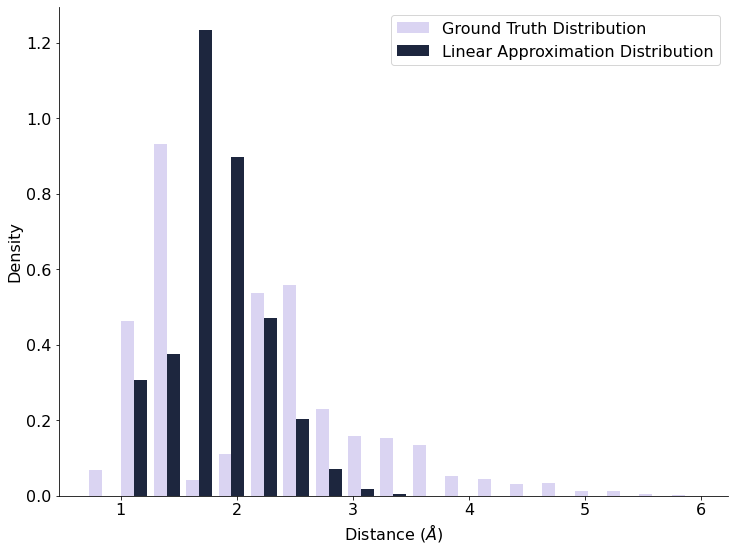

In [51]:
fig, ax = plt.subplots(figsize=(12,9))

# note: if you do linspace(0, ...) then you get lots of zeroes where they are the same
bins = np.linspace(0.7, 6, 20)
ax.hist([train_gt_all, train_la_all], bins, density=True,\
        label=['Ground Truth Distribution', 'Linear Approximation Distribution'],\
       color=sns.cubehelix_palette(2, start=2.8, rot=.1))
ax.legend(loc='upper right')

ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)   

# figs_folder = 'Users/rmhavij/3d-reactions/notebooks/figs/'
# plt.savefig(figs_folder + 'distance_distributions.png', bbox_inches='tight')

/anaconda/envs/tsir-rdkit-env-plotting/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/tsir-rdkit-env-plotting/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


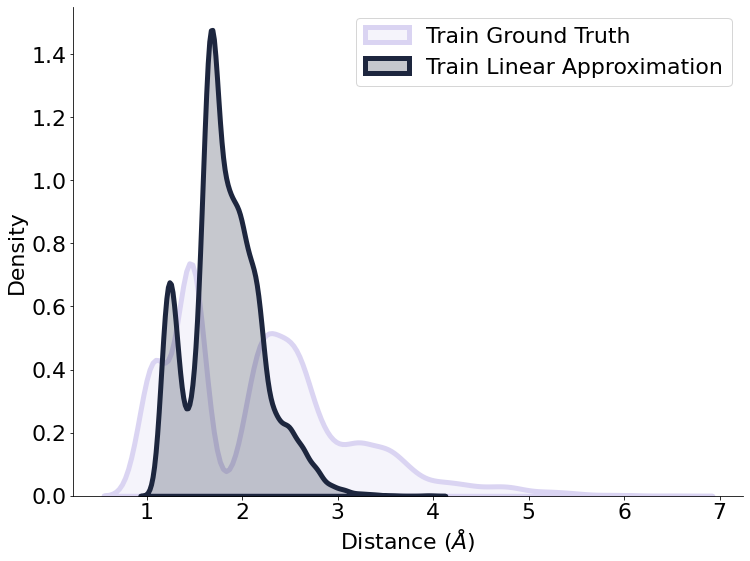

In [52]:
fig, ax = plt.subplots(figsize=(12,9))

num_distr = 2
# may need clearer colours here!
cols = sns.cubehelix_palette(num_distr, start=2.8, rot=.1)

#sns.distplot(train_gt_all, color=cols[0], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Ground Truth"})
#sns.distplot(train_la_all, color=cols[1], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Linear Approximation"})

sns.distplot(train_gt_all, color=cols[0], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Ground Truth"}, hist=False)
sns.distplot(train_la_all, color=cols[1], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Linear Approximation"}, hist=False)

ax.legend(loc='best')

ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize=22)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

figs_folder = 'Users/rmhavij/3d-reactions/notebooks/figs/'
# plt.savefig(figs_folder + 'distance_distributions_nice.png', bbox_inches='tight')